In [2]:
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import uproot
import utils
import yaml
from tensorflow import keras
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import copy

In [3]:
torch.cuda.empty_cache()

### Preprocessing

author @Javier Duarte <br>
https://jduarte.physics.ucsd.edu/capstone-particle-physics-domain/weeks/05-jet-images.html

In [4]:
with open('definitions_image.yml') as file:
    definitions = yaml.load(file, Loader=yaml.FullLoader)

In [5]:
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']

In [6]:
# convert to torch
def keras_to_torch(X, y):
    X_torch = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_torch = torch.tensor(y, dtype=torch.long)
    return X_torch, y_torch

In [7]:
#load training file
feature_array, y, spec_array = utils.get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root', 
                                                         features, 
                                                         spectators, 
                                                         labels, 
                                                         remove_mass_pt_window=False, 
                                                         entry_stop=20000)

In [8]:
# convert the one-hot label to one column only. 0 for QCD and 1 for Higgs Boson
y = y[:,1]

In [9]:
# see if the training set is unbalanced
train_background = 0
for temp in y:
    if temp == 0:
        train_background +=1
print(f"The portion of background data in the training dataset is {train_background / len(y)}"  )

The portion of background data in the training dataset is 0.8678893213200405


In [10]:
# drop some data with label=0 to make the training set balanced
ratio = 0.2
feature_resampled = []
y_resampled = []
for i in range(y.shape[0]):
    if y[i] == 0:
        if np.random.random() < ratio:
            feature_resampled.append(feature_array[i])
            y_resampled.append(y[i])
    else:
        feature_resampled.append(feature_array[i])
        y_resampled.append(y[i])

# Convert the lists to NumPy arrays
feature_resampled = np.array(feature_resampled)
y_resampled = np.array(y_resampled)

In [11]:
# show the new protion of QCD in training set
train_background_resampled = 0
for temp in y_resampled:
    if temp == 0:
        train_background_resampled +=1
print(f"The portion of background data in the resampled training dataset is {train_background_resampled / len(y_resampled)}"  )

The portion of background data in the resampled training dataset is 0.5703883495145631


In [12]:
# make image
X = utils.make_image(feature_resampled)
# image is a 4D tensor (n_samples, n_pixels_x, n_pixels_y, n_channels)
X_train, y_train = keras_to_torch(X, y_resampled)

In [13]:
# load test file
feature_array_test, label_array_test, spec_array_test = utils.get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root', 
                                                                                  features, 
                                                                                  spectators, 
                                                                                  labels, 
                                                                                  remove_mass_pt_window=False, 
                                                                                  entry_stop=2500)


In [14]:
# make image
X_test = utils.make_image(feature_array_test)
X_test, y_test = keras_to_torch(X_test, label_array_test)

In [15]:
# convert the one-hot label to one binary column
# notice that we did not banlance the test dataset so that it reveals the original dataset
y_test = y_test[:,1]
y_test

tensor([0, 0, 1,  ..., 0, 0, 0])

### Model

In [16]:
def conv_output_size(input_size, kernel_size, stride, padding):
    return (input_size - kernel_size + 2 * padding) // stride + 1

In [17]:
# define the main network
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()
        
        print(input_shape)
        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.lrn1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.lrn2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Inception modules
        self.inc1 = Inception_Module(64, 'inc1')
        self.inc2 = Inception_Module(256, 'inc2')
        
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # More inception modules
        self.inc3 = Inception_Module(256, 'inc3')
        
        self.pool4 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

# commented out the relu layers because the paper did not do so
    def forward(self, x):
        x = self.conv1(x)
        #x = self.relu1(x)
        x = self.pool1(x)
        x = self.lrn1(x)

        x = self.conv2(x)
        #x = self.relu2(x)

        x = self.conv3(x)
        #x = self.relu3(x)
        x = self.lrn2(x)
        x = self.pool2(x)

        # Inception modules
        x = self.inc1(x)
        x = self.inc2(x)

        x = self.pool3(x)

        # More inception modules
        x = self.inc3(x)

        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

In [18]:
# define sub-networks
class Inception_Module(nn.Module):
    def __init__(self, in_channels, name):
        super(Inception_Module, self).__init__()
        
        self.conv_a1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        nn.init.kaiming_normal_(self.conv_a1.weight, mode='fan_out', nonlinearity='relu')
        self.conv_b1 = nn.Conv2d(in_channels, 96, kernel_size=1)
        nn.init.kaiming_normal_(self.conv_b1.weight, mode='fan_out', nonlinearity='relu')
        self.conv_c1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.pool_d1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        self.conv_b2 = nn.Conv2d(96, 128, kernel_size=3, padding=1)
        self.conv_c2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv_d2 = nn.Conv2d(in_channels, 32, kernel_size=1)

    def forward(self, x):
        a1 = self.conv_a1(x)
        b1 = self.conv_b1(x)
        c1 = self.conv_c1(x)
        d1 = self.pool_d1(x)
        
        b2 = self.conv_b2(b1)
        c2 = self.conv_c2(c1)
        d2 = self.conv_d2(d1)

        output = torch.cat((a1, b2, c2, d2), dim=1)
        return output

### Training Preparation

In [19]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        
    # training function
    def train(self, epochs, learning_rate):
        train_losses = []
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=0.9)

        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(self.train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_losses.append(running_loss / (i + 1))
            print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}')
        return train_losses
    
    # Testing function
    def test(self):
        correct = 0
        total = 0
        predicts = []
        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                # threshold to adjust the sensitivity to label 1
                predicted = (probs[:, 1] > 0.5).long()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicts.append(predicted)
        print('Accuracy: %d %%' % (100 * correct / total))
        return predicts
        
    # ROC plotter
    def plot_roc_curve(self):
        y_true = []
        y_scores = []
        
        self.model.eval()
        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                
                y_true.extend(labels.cpu().numpy())
                y_scores.extend(probs[:, 1].cpu().numpy())
        
        y_true = np.array(y_true)
        y_scores = np.array(y_scores)

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


In [16]:
# Define the dataset class
class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
# load the data
train_dataset = Data(X_train, y_train)
test_dataset = Data(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

input_shape = X_train.shape[1:]
num_classes = 2

In [18]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Begin Training

In [23]:
# Instantiate the model and trainer
model = CNNModel(input_shape, num_classes=num_classes)
trainer = Trainer(model, train_loader, test_loader, device)

torch.Size([1, 224, 224])


In [24]:
# Train the model
train_losses = trainer.train(epochs=20, learning_rate=0.0005)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1, Loss: 0.6863377938109837
Epoch 2, Loss: 0.6864830426285776
Epoch 3, Loss: 0.6860139239370153
Epoch 4, Loss: 0.6850652316313112
Epoch 5, Loss: 0.6858935349442986
Epoch 6, Loss: 0.6854985955725895
Epoch 7, Loss: 0.6855202454529451
Epoch 8, Loss: 0.6858755731850528
Epoch 9, Loss: 0.6860111995359485
Epoch 10, Loss: 0.6857830637626434
Epoch 11, Loss: 0.6857759855436475
Epoch 12, Loss: 0.6859806615315126
Epoch 13, Loss: 0.685598343275906
Epoch 14, Loss: 0.6862292165836591
Epoch 15, Loss: 0.6855182034915752
Epoch 16, Loss: 0.685670750194721
Epoch 17, Loss: 0.6856894533285934
Epoch 18, Loss: 0.6853136507312904
Epoch 19, Loss: 0.6857967668035058
Epoch 20, Loss: 0.6852512664339515


Notice that the loss does not change much every time. So I just let it iterate few epochs

### Evaluation

In [25]:
# test the model
predicted_labels = trainer.test()
predicted_labels

Accuracy: 86 %


[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

We can see that the model cannot identify the two classes effectively, because it predicts all 0 (or all 1 if we set the threshold in the testing function to be less than 0.5) for every datapoint.

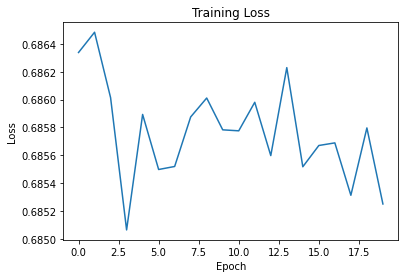

In [26]:
# plot the training losses
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

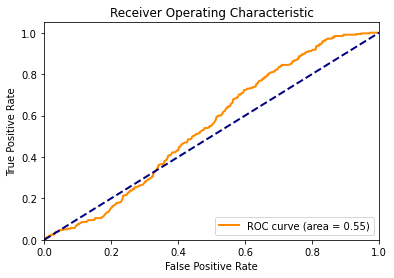

In [27]:
# plot the ROC
trainer.plot_roc_curve()

So far we realized that CVN might not be ideal for this classification task, either because we implemented it with bugs (but we've checked for days!) or because this model cannot effectively identify the trivial differences between different images. <br>
<br>
This reminds me of the fine-grained classification, which is to classify trivial differences between classes. Let's try with a model designed for this task. <br>
<br>
reference paper: Bilinear CNNs for Fine-grained Visual Recognition https://arxiv.org/abs/1504.07889

## Fine grained classification using Bilinear CNN

Data pre-prossesing same as before, so did not write new cells

### Model

In [21]:
# load the data
train_dataset = Data(X_train, y_train)
test_dataset = Data(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

input_shape = X_train.shape[1:]
num_classes = 2

In [22]:
# split the train dataset into training and validation
validation_split = 0.2
train_len = int(len(train_dataset) * (1 - validation_split))
val_len = len(train_dataset) - train_len

train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [23]:
class BilinearCNN(nn.Module):
    def __init__(self, num_classes):
        super(BilinearCNN, self).__init__()

        vgg16 = models.vgg16_bn(pretrained=False)
        features = vgg16.features

        self.feature_extractor_1 = features
        self.feature_extractor_2 = features

        num_features = 512

        self.bilinear = nn.Bilinear(num_features, num_features, num_classes)

        nn.init.xavier_normal_(self.bilinear.weight)

    def forward(self, x):
        # match with required input size
        x = x.repeat(1, 3, 1, 1)
        x1 = self.feature_extractor_1(x)
        x2 = self.feature_extractor_2(x)

        x1 = nn.AdaptiveAvgPool2d((1, 1))(x1)
        x2 = nn.AdaptiveAvgPool2d((1, 1))(x2)

        # Flatten
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)

        x = self.bilinear(x1, x2)
        return x

In [24]:
model = BilinearCNN(num_classes).to(device)

### Training

In [25]:
# model setup
lr = 0.0001
criterion = nn.CrossEntropyLoss()
# weight decay to prevent overfitting
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [26]:
num_epochs = 100
losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
best_model = None
count = 0

# training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    
    # validation with early stopping
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model = copy.deepcopy(model)
        count = 0
    else:
        count += 1

    if count >= patience:
        print("Early stopping due to no improvement in validation loss.")
        break

print("Finished Training.")
model = best_model

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/100, Training Loss: 0.8333, Val Loss: 0.5770
Epoch 2/100, Training Loss: 0.5266, Val Loss: 2.4775
Epoch 3/100, Training Loss: 0.4899, Val Loss: 2.4873
Epoch 4/100, Training Loss: 0.4827, Val Loss: 0.5752
Epoch 5/100, Training Loss: 0.4739, Val Loss: 1.4217
Epoch 6/100, Training Loss: 0.4356, Val Loss: 1.4138
Epoch 7/100, Training Loss: 0.4270, Val Loss: 1.2367
Epoch 8/100, Training Loss: 0.4204, Val Loss: 1.5688
Epoch 9/100, Training Loss: 0.3955, Val Loss: 0.5292
Epoch 10/100, Training Loss: 0.3851, Val Loss: 1.5437
Epoch 11/100, Training Loss: 0.3819, Val Loss: 0.6695
Epoch 12/100, Training Loss: 0.3633, Val Loss: 0.8325
Epoch 13/100, Training Loss: 0.3514, Val Loss: 1.6651
Epoch 14/100, Training Loss: 0.3314, Val Loss: 0.9435
Epoch 15/100, Training Loss: 0.3329, Val Loss: 1.2756
Epoch 16/100, Training Loss: 0.3063, Val Loss: 1.8632
Epoch 17/100, Training Loss: 0.2971, Val Loss: 1.0105
Epoch 18/100, Training Loss: 0.3540, Val Loss: 1.6500
Epoch 19/100, Training Loss: 0.2747, 

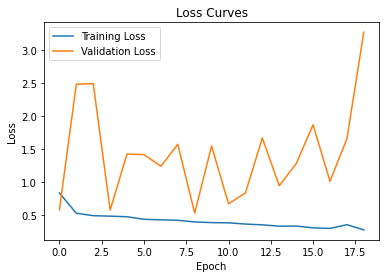

In [27]:
# plot the training loss curve
plt.figure()
plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

### Evaluation

In [28]:
# test the model
model.eval()
y_test_true = []
y_test_pred = []
y_test_score = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_test_true.extend(labels.cpu().numpy())
        y_test_pred.extend(predicted.cpu().numpy())
        y_test_score.extend(probabilities[:, 1].cpu().numpy())

accuracy = correct / total
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 87.39%


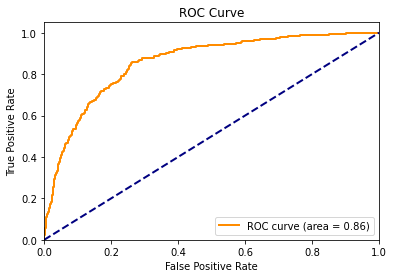

In [29]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_true, y_test_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()